## Word Prediction in a Mobile Device Federation

- Bruno Aurélio Rozza de Moura Campos (202106102)
- Larissa Rozza Peluso (202106341)

### Load Libraries

In [2]:
# data analysis and data wrangling
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython.display import display
from PIL import Image

from plotly.offline import plot, iplot
import plotly.graph_objs as go # create graphics
import plotly.offline as py
import plotly

import cufflinks as cf # conect ploty and pandas
import plotly.io as pio

# preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
import pyLDAvis.sklearn

# ml and dl
# import tensorflow_federated as tff
import tensorflow as tf
import nest_asyncio

## Natural Processing Language
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk

# other
from imp import reload

# import platform
import warnings
import pathlib
import pprint
import string
import json
import time
import re
import os

In [3]:
print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.8.10
Tensorflow version: 2.8.0-dev20211203
Keras version: 2.8.0


#### Set Visualization

In [7]:
# Guarantees visualization inside the jupyter
%matplotlib inline

# formata os dados de todas as tabelas (ponto flutuante com 2 casas)
pd.options.display.float_format = '{:.2f}'.format

# Print all rows and columns. Dont hide any
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Definition color and map de colors
default_color = '#56B4E9'

# Supress unnecessary warnings so that presentation looks clean
warnings.filterwarnings(action='ignore')

pp = pprint.PrettyPrinter(indent=4)
nest_asyncio.apply()

#### Set Ploty

In [8]:
cf.go_offline()
plotly.offline.init_notebook_mode(connected = True)
pio.renderers
pio.renderers.default = 'jupyterlab'

### Prepare Work Directory 

In [9]:
def prepare_work_directory(end_directory: str='notebooks'):
    # Current path
    curr_dir = os.path.dirname(os.path.realpath("__file__")) 
    
    if curr_dir.endswith(end_directory):
        os.chdir('..')
        return curr_dir
    
    return f'Current working directory: {curr_dir}' 

In [10]:
prepare_work_directory(end_directory='notebooks')

'/home/campos/projects/ml/federated-Learning-for-text-generation/notebooks'

# **Business Understanding**


## Project Plan
1. Get the data
2. Data Describe 
3. Preprocessing 
4. Data exploration
5. Create tensors. `NOTE: From this point on, the data is in the same pattern as the tff simulation module`
7. Data Federated Understanding
8. Load the Federated Data. `NOTE: now on the next steps will be done on a federation client`
10. Preprocess the Data 
11. Load pre-trained model each client
12. Compile the model and test on the preprocessed data
13. Fine-tune the model with Federated Learning

# **Data Understanding**

## **Collect Initial Data**
- The data consists in Shakespeare play.
- Hosted in [Project Gutenberg](https://www.gutenberg.org/).

In [11]:
%%time

!bash src/download_dataset.sh \
    -u http://www.gutenberg.org/files/100/old/1994-01-100.zip \
    -p data/raw

----------------------------------------
----------- Downloading data -----------
----------------------------------------
--2021-12-05 19:52:01--  http://www.gutenberg.org/files/100/old/1994-01-100.zip
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.gutenberg.org/files/100/old/1994-01-100.zip [following]
--2021-12-05 19:52:02--  https://www.gutenberg.org/files/100/old/1994-01-100.zip
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2035857 (1,9M) [application/zip]
Saving to: ‘data/raw/temp_file.zip’

data/raw/temp_file. 100%[===================>]   1,94M  1,20MB/s    in 1,6s    

2021-12-05 19:52:04 (1,20 MB/s) - ‘data/raw/temp_file.zip’ saved [2035857/2035857]

-------------------------------

In [12]:
%%time

raw_data = open('data/raw/100.txt', mode='r').read()

CPU times: user 3.37 ms, sys: 16.1 ms, total: 19.5 ms
Wall time: 18.4 ms


## **Describe Data**


In [13]:
count_rows = raw_data.count('\n')
unique_char = sorted(set(raw_data))
list_words_tokens = word_tokenize(raw_data)

In [16]:
print(f'Total rows: {count_rows}')
print(f'Total tokens: {len(list_words_tokens)}')
print(f'Total characters: {len(raw_data)}')
print(f'Total unique character: {len(unique_char)}')
print(f'\nSample:\n{raw_data[:500]}')

Total rows: 124788
Total tokens: 1134708
Total characters: 5465129
Total unique character: 91

Sample:
The Project Gutenberg EBook of The Complete Works of William Shakespeare, by
William Shakespeare

This eBook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever.  You may copy it, give it away or
re-use it under the terms of the Project Gutenberg License included
with this eBook or online at www.gutenberg.org

** This is a COPYRIGHTED Project Gutenberg eBook, Details Below **
**     Please follow the copyright guidelines in this file.     **

Title: The Comple


### The unique characters in the file

In [12]:
print('characters:\n', unique_char)

characters:
 ['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '}', '~']


### Dataset General Information
- The data set is in text format
- It has 
  - 124.788 rows 
  - 5.465.129 characters
  - 91 unique characteres

## **Preprocessing**

In [17]:
def remove_unnecessary_text(str_shakespeare_full: str, int_last_line: int):
    """
    Remove:
        -> the first lines
        -> the last lines
        -> the poems
        -> This piece:
            '<<THIS ELECTRONIC VERSION OF THE COMPLETE WORKS OF WILLIAM
                SHAKESPEARE IS COPYRIGHT 1990-1993 BY WORLD LIBRARY, INC., AND IS
                PROVIDED BY PROJECT GUTENBERG ETEXT OF ILLINOIS BENEDICTINE COLLEGE
                WITH PERMISSION.  ELECTRONIC AND MACHINE READABLE COPIES MAY BE
                DISTRIBUTED SO LONG AS SUCH COPIES (1) ARE FOR YOUR OR OTHERS
                PERSONAL USE ONLY, AND (2) ARE NOT DISTRIBUTED OR USED
                COMMERCIALLY.  PROHIBITED COMMERCIAL DISTRIBUTION INCLUDES BY ANY
                SERVICE THAT CHARGES FOR DOWNLOAD TIME OR FOR MEMBERSHIP.>>'
    """    
    str_pre_clean = re.sub("<(.+)\n(.+)\n(.+)\n(.+)\n(.+)\n(.+)\n(.+)\n(.+)",
                           '',
                           str_shakespeare_full)
    
    slines = str_pre_clean.splitlines(keepends=True)[1:int_last_line]
    author_count = 0
    start_line = 1
    
    for i, row in enumerate(slines):        
        # under the title always appears "by William Shakespeare"
        if 'by William Shakespeare' in row: 
            author_count += 1
        
        # position where the first play starts
        if author_count == 2:
            start_line = i - 5
            break
    
    return slines[(start_line + 2):]

In [18]:
data_pre_cleansing = remove_unnecessary_text(str_shakespeare_full=raw_data,
                                             int_last_line=122343)
data_pre_cleansing[1300]

'    Which, as your due, time claims, he does acknowledge;\n'

In [20]:
data_cleansing = [x.lstrip() for x in data_pre_cleansing]
data_cleansing[1300]

'Which, as your due, time claims, he does acknowledge;\n'

#### Save text with new formatting

In [21]:
data_cleansing_txt = " ".join(str(x) for x in data_cleansing)

with open('data/cleansing/data_preprocess.txt', mode='w') as w:
    w.write(str(data_cleansing_txt))

### Create a mapping from unique characters to indices

In [24]:
char2idx = {u:i for i, u in enumerate(unique_char)}
idx2char = np.array(unique_char)

### Bag Of Words
TODO

In [25]:
def create_bag_of_words(list_words: list, ngram: int) -> list:
    vec = CountVectorizer(ngram_range=(ngram, ngram),
                          stop_words="english",
                          lowercase=True)
    
    bag_of_words = vec.fit_transform(list_words)
    sum_words = bag_of_words.sum(axis=0)

    return [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

### TFIDF
TODO

In [26]:
def tfidf_vectorizer(documents, total_features: int):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95,
                                       min_df=2,
                                       max_features=total_features,
                                       stop_words='english')
    tfidf = tfidf_vectorizer.fit_transform(documents)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()

    return tfidf_vectorizer, tfidf, tfidf_feature_names

def count_vectorizer(documents, total_features: int):
    tf_vectorizer = CountVectorizer(max_df=0.95, 
                                    min_df=2,
                                    max_features=total_features,
                                    stop_words='english')
    tf = tf_vectorizer.fit_transform(documents)
    tf_feature_names = tf_vectorizer.get_feature_names()
    return tf_vectorizer, tf, tf_feature_names

In [27]:
total_features = 15000
no_top_words = 8

In [28]:
tfidf_vectorizer, tfidf, tfidf_feature_names = tfidf_vectorizer(data_cleansing,
                                                                total_features)
tf_vectorizer, tf, tf_feature_names = count_vectorizer(data_cleansing, 
                                                       total_features)

**NOTES**:
- Stemming (radical)
- Lemmatization (base form)

---

## **Explore Data**


In [29]:
bag_of_words = create_bag_of_words(list_words=data_cleansing, ngram=1)

In [30]:
def get_top_n_words(bag_of_words, n_elements) -> list:
    return sorted(bag_of_words, key = lambda x: x[1], reverse=True)[:n_elements]

In [32]:
top_20_words = get_top_n_words(bag_of_words, 20)
top_20_words

[('thou', 5307),
 ('thy', 3745),
 ('shall', 3538),
 ('lord', 3093),
 ('king', 3039),
 ('thee', 3018),
 ('good', 2818),
 ('sir', 2758),
 ('come', 2500),
 ('ll', 2400),
 ('enter', 2357),
 ('let', 2341),
 ('man', 2020),
 ('love', 1993),
 ('hath', 1890),
 ('like', 1745),
 ('say', 1724),
 ('know', 1717),
 ('make', 1589),
 ('did', 1576)]

#### Create Dataframe


In [34]:
df_unigram = pd.DataFrame(top_20_words, columns = ['word' , 'count'])
df_unigram.head()

,word,count
0,thou,5307
1,thy,3745
2,shall,3538
3,lord,3093
4,king,3039


#### The distribution of top unigrams after removing stop words

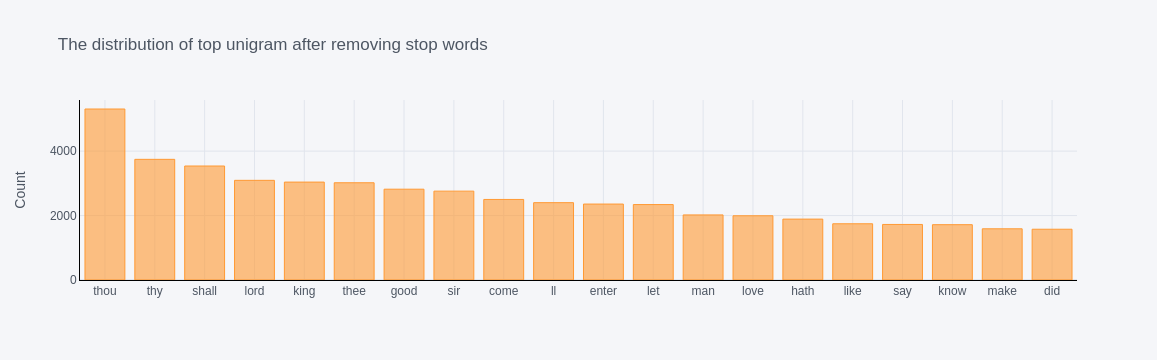

In [35]:
df_unigram\
  .groupby('word')\
  .sum()['count']\
  .sort_values(ascending=False)\
  .iplot(kind='bar',
         yTitle='Count',
         linecolor='black',
         title='The distribution of top unigram after removing stop words')

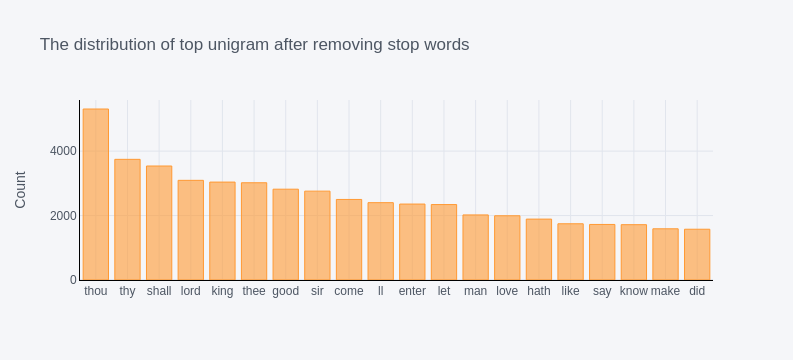

In [36]:
# ploty -> static image
display(Image.open('reports/unigram.png'))

The distribution of top bigrams after removing stop words


In [38]:
bag_of_words_bigram = create_bag_of_words(data_cleansing, ngram=2)

In [40]:
top_20_words_bigram = get_top_n_words(bag_of_words_bigram, 20)
top_20_words_bigram

[('thou art', 501),
 ('king henry', 399),
 ('thou hast', 354),
 ('king richard', 277),
 ('st thou', 249),
 ('good lord', 239),
 ('thou shalt', 226),
 ('art thou', 225),
 ('ne er', 212),
 ('dost thou', 208),
 ('sir toby', 199),
 ('sir john', 164),
 ('thou dost', 151),
 ('hast thou', 150),
 ('king edward', 150),
 ('thou wilt', 141),
 ('wilt thou', 134),
 ('come come', 128),
 ('scene ii', 124),
 ('king john', 123)]

In [41]:
df_bigram = pd.DataFrame(top_20_words_bigram, columns = ['word' , 'count'])
df_bigram.head()

,word,count
0,thou art,501
1,king henry,399
2,thou hast,354
3,king richard,277
4,st thou,249


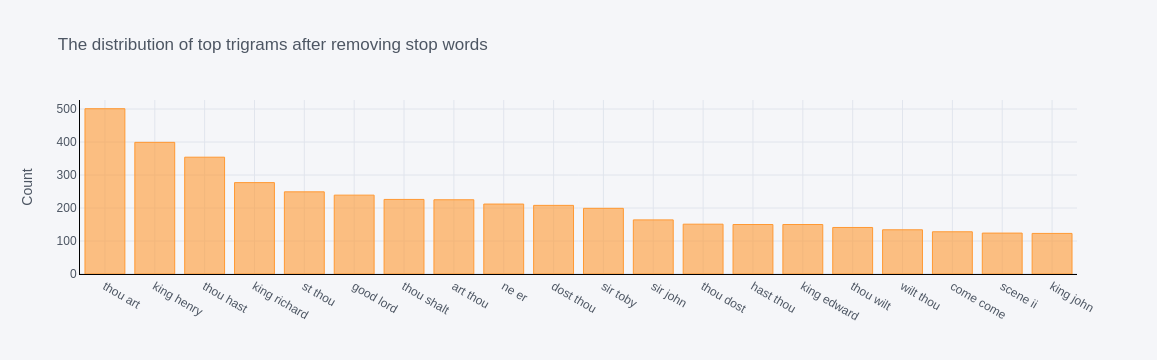

In [42]:
df_bigram\
  .groupby('word')\
  .sum()['count']\
  .sort_values(ascending=False)\
  .iplot(kind='bar',
         yTitle='Count',
         linecolor='black',
         title='The distribution of top trigrams after removing stop words')

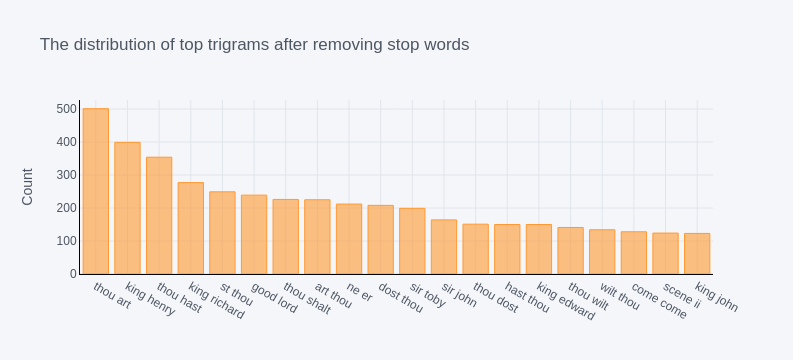

In [42]:
# ploty -> static image
display(Image.open('reports/bigram.png'))

### Latent Dirichlet Allocation (LDA) 
Latent Dirichlet allocation (LDA) is a technique that automatically discovers topics that these documents contain

#### For example
if you know you have a topic about **Apple** products it can be helpful to bias words like **iphone** and **ipad** for one of the topics in order to push the model towards finding that particular topic.

<!-- projetada para auxiliar na modelagem de dados que consistem em um grande corpus de palavras.
O LDA é baseado em duas suposições gerais:
- Documentos que têm palavras semelhantes geralmente têm o mesmo tópico
- Documentos que têm grupos de palavras que ocorrem frequentemente juntas geralmente têm o mesmo tópico.


O raciocínio é:
- Documentos são distribuições de probabilidade sobre tópicos latentes
- Tópicos são distribuições de probabilidade sobre palavras
 -->


In [43]:
%%time

model_lda = LatentDirichletAllocation(max_iter=30,
                                      learning_method='online',
                                      learning_offset=50.,
                                      random_state=0).fit(tfidf)

model_lda

CPU times: user 7min 10s, sys: 740 ms, total: 7min 11s
Wall time: 7min 12s


LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=30, random_state=0)

In [32]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic:", (topic_idx))
        print(" ".join([feature_names[i]
        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [33]:
display_topics(model_lda, tfidf_feature_names, no_top_words)

Topic: 0
scene th hand lord pray son brother eyes
Topic: 1
let king come away grace till richard bear
Topic: 2
enter know speak man tell honour blood better
Topic: 3
exit men doth day poor long farewell heard
Topic: 4
say exeunt queen like fair prince comes heaven
Topic: 5
time love master night fear god caesar servant
Topic: 6
thou hath duke thee think st good art
Topic: 7
heart lady hear life true john bring hold
Topic: 8
shall make sir peace word head mistress place
Topic: 9
look did world tis sweet nay wife death


### Display Topic Modelling

In [34]:
data_op = pyLDAvis.sklearn.prepare(model_lda, 
                                   tfidf,
                                   tfidf_vectorizer)

pyLDAvis.enable_notebook()
pyLDAvis.display(data_op)

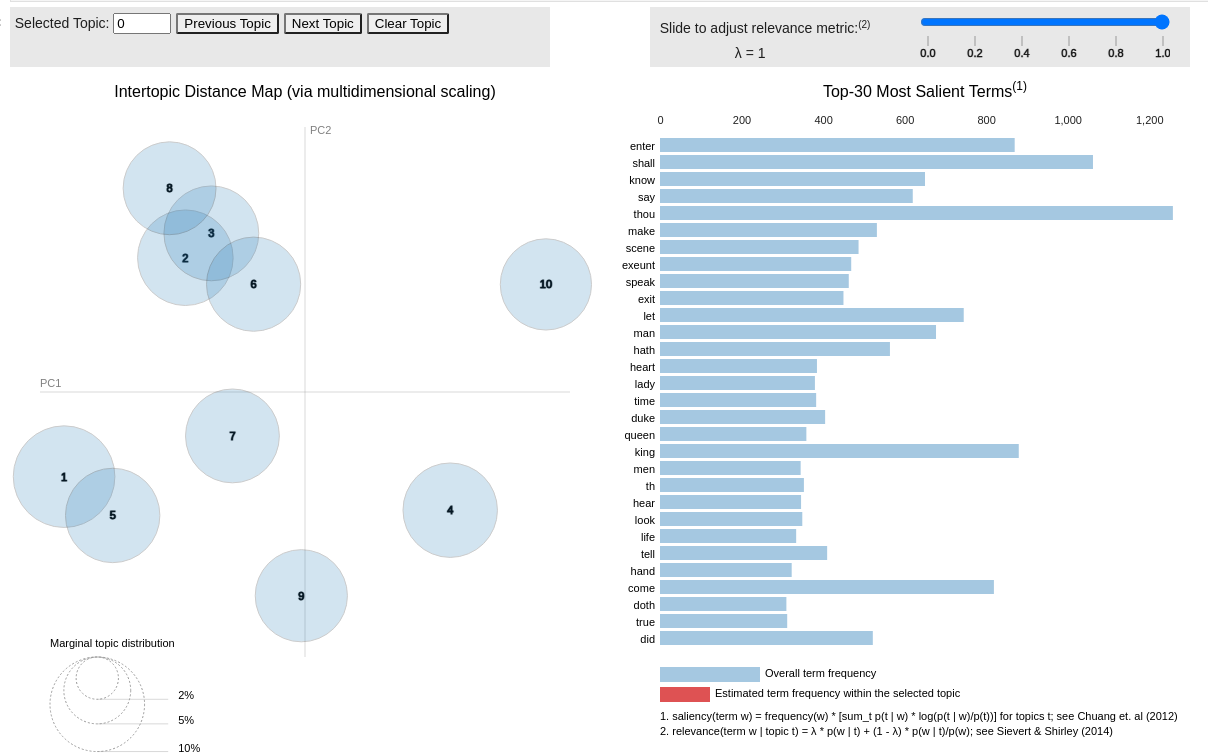

In [43]:
# ploty -> static image
display(Image.open('reports/lda_intertopic.png'))

### Wordcloud

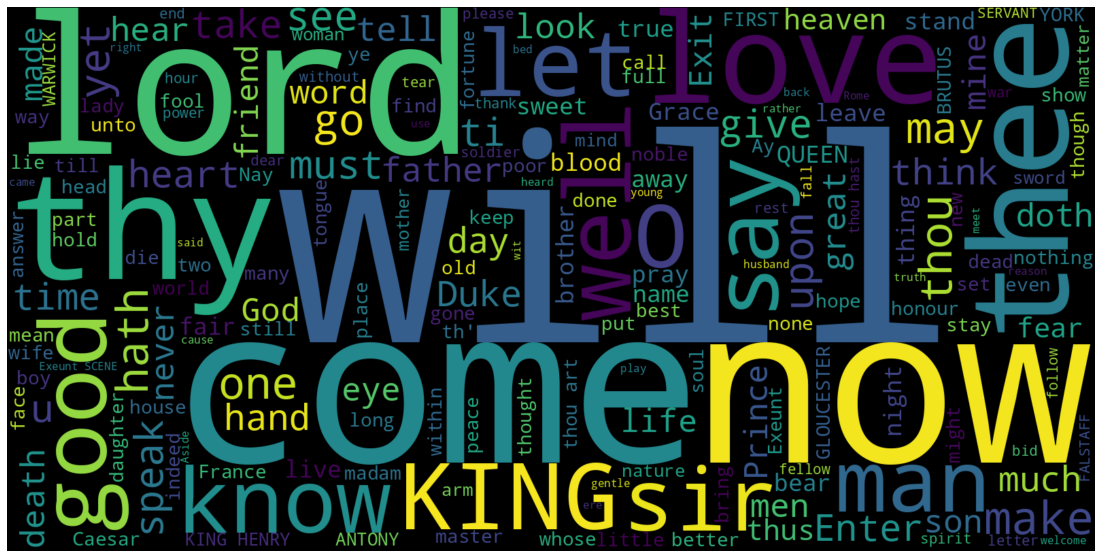

In [46]:
wordcloud = WordCloud(background_color="black",
                      width=1600, 
                      height=800).generate(data_cleansing_txt)

# show
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()

## **Prepare Data to RNN**

In [49]:
tf_dataset = [tf.constant(str(row)) for row in data_cleansing]
type(tf_dataset[0])

tensorflow.python.framework.ops.EagerTensor

In [50]:
tf_dataset[5000]

<tf.Tensor: shape=(), dtype=string, numpy=b'And neither way inclines.\n'>

---